# Train Simulated Data Classifier

Train a classifier on Alex's [simulated data](https://github.com/braingeneers/organoid-net/issues/3). The simulated PNG's with labels have been converted into Tensorflow's native binary format, tfrecords via an [ingest notebook](https://github.com/braingeneers/organoid-net/blob/master/simulated/ingest.ipynb) and stored in the PRP S3/CEPH store so they are publicly accesible. If we can classify we can identify which features/pixels in the input image are being stimulated by whatever is stimulating the organoid and thereby determine if output is based on input.

In [1]:
import os
import json
import requests

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # reproducibility

import tensorflow as tf
# Eager mode and multi-gpu training have some issues with Keras currently (tf 1.12)
# https://github.com/tensorflow/tensorflow/issues/20999
# tf.enable_eager_execution()

# See if we have a GPU - if not check Edit->Notebook Settings for GPU/TPU options
# In a prelimary test the GPU took ~2.5 minutes to train vs. ~4-5 minutes for the TPU,
# but the TPU required less power and therefore is the green choice :-)
print("GPU Available:", tf.test.is_gpu_available())

# Turn down the significant TF debugging output when hitting S3
# 0=All, 1=Filter Info, 2=Filter Warning, 3=Filter Error
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

# Simple syntatic sugar for debug vs. train parameters
def debug(debug_param, no_debug_param):
    return debug_param if os.environ.get("DEBUG") else no_debug_param
print(debug("DEBUG: ON", "DEBUG: OFF"))

GPU Available: False
DEBUG: ON


In [2]:
# Connect to S3 via boto3 so we can read and write
import boto3

bucket_name = "braingeneers"

session = boto3.session.Session(profile_name=os.getenv("AWS_PROFILE"))
bucket = session.resource(
    "s3", endpoint_url=os.getenv("AWS_S3_ENDPOINT")).Bucket(bucket_name)
print("S3 Profile: {} Endpoint: {} Bucket: {}".format(
    os.getenv("AWS_PROFILE"), os.getenv("AWS_S3_ENDPOINT"), bucket_name))

S3 Profile: prp Endpoint: https://s3.nautilus.optiputer.net Bucket: braingeneers


In [3]:
# Read in metadata for a dataset
dataset_name = "simulated"
print("Reading {} dataset".format(dataset_name))

metadata = json.loads(bucket.Object(
    dataset_name + "/metadata.json").get()['Body'].read().decode('utf-8'))
print("Dataset metadata keys:", list(metadata.keys()))
print("{} train and {} test samples with {} labels".format(
    metadata["num_train_examples"], metadata["num_test_examples"], len(metadata["labels"])))

Reading simulated dataset
Dataset metadata keys: ['image_height', 'num_test_examples', 'num_train_examples', 'test_examples_name', 'data_set', 'train_examples_name', 'description', 'labels', 'image_width']
8000 train and 2000 test samples with 49 labels


## Tensor Flow Dataset

For this small of a dataset this is overkill. But it demonstrates how to build a lazy data pipeline with data modification such that it will feed the Tensorflow engine natively at training time. Data augmentation via tf.image.* can easily be added and this general pattern will likely be useful when we have big data sets and video in PRP.

In [4]:
batch_size = 128

def parse_one_example(example):
    example = tf.parse_single_example(example, features = {
        "example": tf.FixedLenFeature([], tf.string),
        "label": tf.FixedLenFeature([], tf.int64)
    })
    
    # Extract the png from the example and convert to numpy
    image = tf.image.decode_png(example["example"], channels=1)
    
    # Optionally resize the image to reduce the size of the neural network
    image = tf.image.resize_images(
        image, [metadata["image_height"] // 4, metadata["image_width"] // 4])
    image = tf.image.per_image_standardization(image)
    
    # One hot encode our label
    label = tf.one_hot(example["label"], len(metadata["labels"]))
    
    return image, label

def create_dataset(files, batch_size, num_classes):
    # Create a data pipeline with shuffling and parallel loading
    # See https://www.tensorflow.org/guide/performance/datasets
    dataset = tf.data.TFRecordDataset(files)
    dataset = dataset.map(parse_one_example, num_parallel_calls=8)
    dataset.cache("tensorflow.cache")
    dataset = dataset.shuffle(8 * num_classes)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(1)
    return dataset

training_dataset = create_dataset(
    ["s3://braingeneers/{}/{}".format(metadata["data_set"], metadata["train_examples_name"])],
    batch_size, len(metadata["labels"]))
test_dataset = create_dataset(
    ["s3://braingeneers/{}/{}".format(metadata["data_set"], metadata["test_examples_name"])],
    batch_size, len(metadata["labels"]))

First image shape: (87, 115, 1)


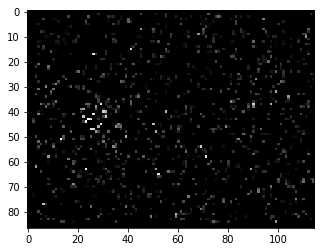

In [5]:
# Display the first image of a batch as a check as well as to get the dimensions
examples, labels = training_dataset.make_one_shot_iterator().get_next()

# Eager Mode
# first_image = examples[0].numpy()

# Non Eager Mode
with tf.Session() as sess:
    first_image = sess.run(examples)[0]

print("First image shape:", first_image.shape)
plt.imshow(first_image.reshape(first_image.shape[0], first_image.shape[1]), cmap="gray")

## Build Model and Train

In [8]:
def create_model(input_shape, output_shape):

    input_layer = tf.keras.Input(shape=input_shape, name="input")

    x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")(input_layer)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)   

    output_layer = tf.keras.layers.Dense(output_shape, activation="softmax", name="output")(x)
        
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  metrics=['accuracy'],
                  optimizer=tf.keras.optimizers.Adam())
    return model

model = create_model(input_shape=(first_image.shape[0], first_image.shape[1], 1),
                     output_shape=len(metadata["labels"]))
model.summary()

model.fit(training_dataset, epochs=debug(1, 10), verbose=1, 
          steps_per_epoch=debug(1, metadata["num_train_examples"] // batch_size),
          callbacks = [tf.keras.callbacks.EarlyStopping(
              monitor="loss", min_delta=0.5, patience=3, verbose=0, mode='auto')])

loss = model.evaluate(test_dataset, steps=1)
print("Loss: {} Accuracy: {}".format(loss[0], loss[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 87, 115, 1)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 113, 64)       640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 42, 56, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 42, 56, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 150528)            602112    
_________________________________________________________________
output (Dense)               (None, 49)                7375921   
Total para

In [12]:
# Save the trained model back to S3 under our username so we don't overwrite other's
import tempfile
src = "/tmp/{}.h5".format(next(tempfile._get_candidate_names()))
model.save(src)

dest = "{}/{}/models/model.h5".format(os.environ["USER"], metadata["data_set"])
bucket.Object(dest).upload_file(src, ExtraArgs={"ACL":"public-read"})
os.remove(src)

print("Saved trained model to {}".format(dest))

Saved trained model to rcurrie/simulated/models/model.h5
